In [28]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.io import ascii
from astropy.table import vstack
from astropy.modeling import models
import corner
import pickle
import os
from timeit import default_timer as timer
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.optimize import least_squares, curve_fit

In [7]:
def load_data(filename='radio_lightcurve.dat'):
    data = ascii.read(filename)
    
    return data

# Make a plot of the radio lightcurve
Make a log-log plot of the flux density as a function of time. Make sure to modularise your code so that we can re-use parts of it later on. For bonus points use different markers for each telescope, and use a colour scale to denote the observation frequency.

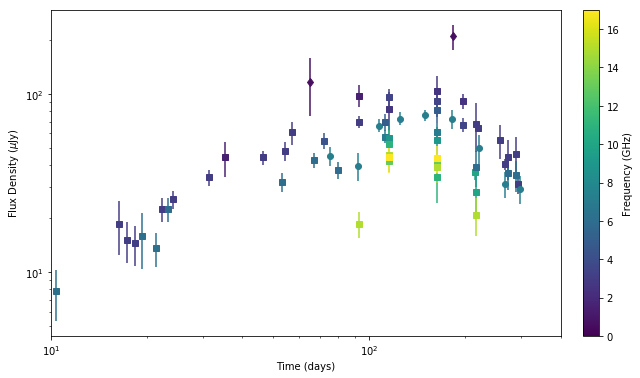

In [27]:
def plot_data(ax, sm, data, **kwargs):
    telescope_marker_dict = {'VLA':'s', 'ATCA':'o', 'GMRT':'d'}
    
    
    for row in data:
        freq = row['frequency']
        colorval = sm.to_rgba(freq)
        
        telescope = row['telescope']
        marker = telescope_marker_dict[telescope]
    
    
        ax.errorbar(row['delta_t'], row['flux'], row['rms'], linestyle='', marker=marker, c=colorval, **kwargs)
    return

def cmap_setup(cmap='viridis', min_freq=0, max_freq=17):
    freq_cmap = plt.cm.get_cmap(cmap)
    min_freq = 0
    max_freq = 17
    
    cNorm  = colors.Normalize(vmin=min_freq, vmax=max_freq)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    sm = scalarMap
    sm._A = []
    
    return sm
    

def make_plot(data):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    
    sm = cmap_setup()
    plot_data(ax, sm, data)
    
    cbar = fig.colorbar(sm,fraction=0.046, pad=0.04)
    cbar.set_label('Frequency (GHz)')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Flux Density ($\mu$Jy)')
    
    ax.set_xlim(10,400)
    
    
data = load_data()
make_plot(data)

# Determining the spectral index
Write a function to take a subset of the data and calculate the spectral index. Using multi-band observation at 162 days post-merger calculate the spectral index.

In [ ]:
def alpha_calc(data):
    freqs = data['frequency']
    flux = data['flux']
    errs = data['rms']
    
    popt, pcov = curve_fit(calc_power_law, freqs, flux ,sigma=flux_errs, p0=(50,-0.61),absolute_sigma=True)
    
    alpha = popt[1]
    alpha_err = np.sqrt(np.diag(pcov))[1]
    
    re